In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import math

In [2]:
dataset = sio.loadmat('anomalyData.mat')
X = dataset['X']
Xval = dataset['Xval']
yval = dataset['yval']

Text(0, 0.5, 'Throughput(mb/s)')

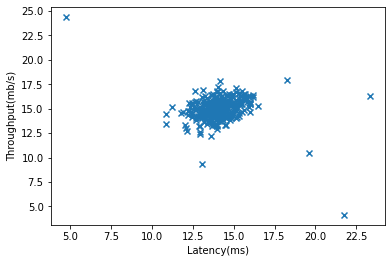

In [3]:
plt.scatter(X[:, 0], X[:, 1], marker = "x")
plt.xlabel('Latency(ms)')
plt.ylabel('Throughput(mb/s)')

In [4]:
def estimateGaussian(X):
    n = np.size(X, 1)
    m = np.size(X, 0)
    mu = np.zeros((n, 1))
    sigma2 = np.zeros((n, 1))
    
    mu = np.reshape((1/m)*np.sum(X, 0), (1, n))
    sigma2 = np.reshape((1/m)*np.sum(np.power((X - mu),2), 0),(1, n))
    
    return mu, sigma2

mu, sigma2 = estimateGaussian(X)

In [5]:
def multivariateGaussian(X, mu, sigma2):
     n = np.size(sigma2, 1)
     m = np.size(sigma2, 0)
     #print(m,n)
     
     if n == 1 or m == 1:
        # print('Yes!')
         sigma2 = np.diag(sigma2[0, :])
     #print(sigma2)
     X = X - mu
     pi = math.pi
     det = np.linalg.det(sigma2)
     inv = np.linalg.inv(sigma2)
     val = np.reshape((-0.5)*np.sum(np.multiply((X@inv),X), 1),(np.size(X, 0), 1))
     #print(val.shape)
     p = np.power(2*pi, -n/2)*np.power(det, -0.5)*np.exp(val)
     
     return p
#we convert the sigma2 vector into a covariance matrix and then we simply apply the formula for the multivariate distribution to get the probability vector. If you’ve passed a vector in sigma2 you’ve to convert it into a matrix with the vector as the diagonal and rest of the element as zero

![<NOM_DU_FICHIER>](./img/multivariate_gaussian.png)

In [7]:
p = multivariateGaussian(X, mu, sigma2)
print(p.shape)

(307, 1)


In [8]:
pval = multivariateGaussian(Xval, mu, sigma2)

In [9]:
def selectThreshHold(yval, pval):
    
    F1 = 0
    bestF1 = 0
    bestEpsilon = 0
    
    stepsize = (np.max(pval) - np.min(pval))/1000
        
    epsVec = np.arange(np.min(pval), np.max(pval), stepsize)
    noe = len(epsVec)
    
    for eps in range(noe):
        epsilon = epsVec[eps]
        pred = (pval < epsilon)
        prec, rec = 0,0
        tp,fp,fn = 0,0,0
        
        try:
            for i in range(np.size(pval,0)):
                if pred[i] == 1 and yval[i] == 1:
                    tp+=1
                elif pred[i] == 1 and yval[i] == 0:
                    fp+=1
                elif pred[i] == 0 and yval[i] == 1:
                    fn+=1
            prec = tp/(tp + fp)
            rec = tp/(tp + fn)
            F1 = 2*prec*rec/(prec + rec)
            if F1 > bestF1:
                bestF1 = F1
                bestEpsilon = epsilon
        except ZeroDivisionError:
            print('Warning dividing by zero!!')          
       
    return bestF1, bestEpsilon
#we find the stepsize to have a wide range of threshold values to decide the best one. We use the F1 score method to determine the best parameters i.e bestepsilon and bestF1. Predict anomaly if pval<epsilon that gives a vector of binary values in the variable predict. F1 score takes into consideration precision and recall.
#In line number 19 I’ve implemented a for loop to calculate the tp, fp, and fn

In [10]:
F1, epsilon = selectThreshHold(yval, pval)
print('Epsilon and F1 are:',epsilon, F1)

Warning dividing by zero!!
Epsilon and F1 are: 8.990852779269493e-05 0.8750000000000001


In [11]:
outl = (p < epsilon)

In [12]:
def findIndices(binVec):
    l = []
    for i in range(len(binVec)):
        if binVec[i] == 1:
            l.append(i)
    return l

In [16]:
listOfOutliers = findIndices(outl)
count_outliers = len(listOfOutliers)
print('\n\nNumber of outliers:', count_outliers)
print('\n',listOfOutliers)



Number of outliers: 6

 [300, 301, 303, 304, 305, 306]


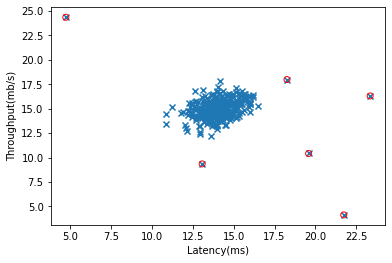

In [17]:

plt.scatter(X[:, 0], X[:, 1], marker = "x")
plt.xlabel('Latency(ms)')
plt.ylabel('Throughput(mb/s)')
plt.scatter(X[listOfOutliers,0], X[listOfOutliers, 1], facecolors = 'none', edgecolors = 'r')
plt.show()

In [18]:


newDataset = sio.loadmat('anomalyDataTest.mat')

Xtest = newDataset['X']
Xvaltest = newDataset['Xval']
yvaltest = newDataset['yval']

In [19]:
mutest, sigma2test = estimateGaussian(Xtest)
ptest = multivariateGaussian(Xtest, mutest, sigma2test)
pvaltest = multivariateGaussian(Xvaltest, mutest, sigma2test)

F1test, epsilontest = selectThreshHold(yvaltest, pvaltest)
print('\nBest epsilon and F1 are\n',epsilontest, F1test)

Warning dividing by zero!!

Best epsilon and F1 are
 1.3772288907613575e-18 0.6153846153846154


In [20]:

outliersTest = ptest < epsilontest
listOfOl = findIndices(outliersTest)

print('\n\n Outliers are:\n',listOfOl)
print('\n\nNumber of outliers are: ',len(listOfOl))



 Outliers are:
 [9, 20, 21, 30, 39, 56, 62, 63, 69, 70, 77, 79, 86, 103, 130, 147, 154, 166, 175, 176, 198, 209, 212, 218, 222, 227, 229, 233, 244, 262, 266, 271, 276, 284, 285, 288, 289, 290, 297, 303, 307, 308, 320, 324, 338, 341, 342, 344, 350, 351, 353, 365, 369, 371, 378, 398, 407, 420, 421, 424, 429, 438, 452, 455, 456, 462, 478, 497, 518, 527, 530, 539, 541, 551, 574, 583, 587, 602, 613, 614, 628, 648, 674, 678, 682, 685, 700, 702, 705, 713, 721, 741, 750, 757, 758, 787, 831, 834, 836, 839, 846, 870, 885, 887, 890, 901, 911, 930, 939, 940, 943, 951, 952, 970, 975, 992, 996]


Number of outliers are:  117


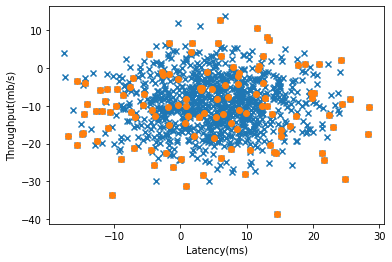

In [24]:
plt.scatter(Xtest[:, 0], Xtest[:, 1], marker = "x")
plt.xlabel('Latency(ms)')
plt.ylabel('Throughput(mb/s)')
plt.scatter(Xtest[listOfOl, 0], Xtest[listOfOl, 1], marker = "o")